In [1]:
# Environment setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Add src to path
workspace_root = Path.cwd()
sys.path.insert(0, str(workspace_root / 'src'))

from thesis_pipeline.io.parquet import read_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"Project root: {workspace_root}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
✓ Environment configured


## 1. Initial Data: Reddit & News Articles

We analyze political discourse from two platforms:
- **Reddit**: Comments from political subreddits (r/politics, r/PoliticalDiscussion, etc.)
- **News Media**: Articles from major US news outlets

**Time Period:** September-October 2016 (US Presidential Election)

### Data Collection & Filtering

- **Reddit**: Downloaded submissions from Pushshift archives and comments from Politosphere dataset, filtered for English political subreddits
- **News**: Streamed from Common Crawl News dataset, filtered for US political content
- **Quality Filters**: Minimum length, spam removal, deduplication

Let's examine the filtered datasets:

In [9]:
# Load filtered data (aggregate daily parquet files)
print("Loading Reddit data...")
reddit_path = workspace_root / 'data' / '01_corpus' / '01_silver' / 'reddit' / 'politosphere'
reddit_files = sorted(reddit_path.glob('*.parquet'))
reddit_dfs = []
for file in reddit_files:
    df = read_parquet(file)
    reddit_dfs.append(df)
reddit_silver = pd.concat(reddit_dfs, ignore_index=True)
print(f"  Loaded {len(reddit_files)} daily files → {len(reddit_silver):,} total comments")

print("\nLoading News data...")
news_path = workspace_root / 'data' / '01_corpus' / '01_silver' / 'news'
news_files = sorted(news_path.glob('*.parquet'))
news_dfs = []
for file in news_files:
    df = read_parquet(file)
    news_dfs.append(df)
news_silver = pd.concat(news_dfs, ignore_index=True)
print(f"  Loaded {len(news_files)} daily files → {len(news_silver):,} total articles")

print("\n" + "="*80)
print("FILTERED DATA OVERVIEW")
print("="*80)

print(f"\nREDDIT:")
print(f"  Total comments: {len(reddit_silver):,}")
print(f"  Date range: {pd.to_datetime(reddit_silver['created_utc'], unit='s').min()} to {pd.to_datetime(reddit_silver['created_utc'], unit='s').max()}")
print(f"  Unique authors: {reddit_silver['author'].nunique():,}")
print(f"  Subreddits: {reddit_silver['subreddit'].nunique()}")

print(f"\nNEWS:")
print(f"  Total articles: {len(news_silver):,}")
print(f"  Date range: {news_silver['published_date'].min()} to {news_silver['published_date'].max()}")
print(f"  Unique sources: {news_silver['sitename'].nunique():,}")

Loading Reddit data...
  Loaded 61 daily files → 8,785,795 total comments

Loading News data...
  Loaded 61 daily files → 93,669 total articles

FILTERED DATA OVERVIEW

REDDIT:
  Total comments: 8,785,795
  Date range: 2016-09-01 00:00:01 to 2016-10-31 23:59:59
  Unique authors: 330,850
  Subreddits: 364

NEWS:
  Total articles: 93,669
  Date range: 2016-09-01 to 2016-10-31
  Unique sources: 2,732


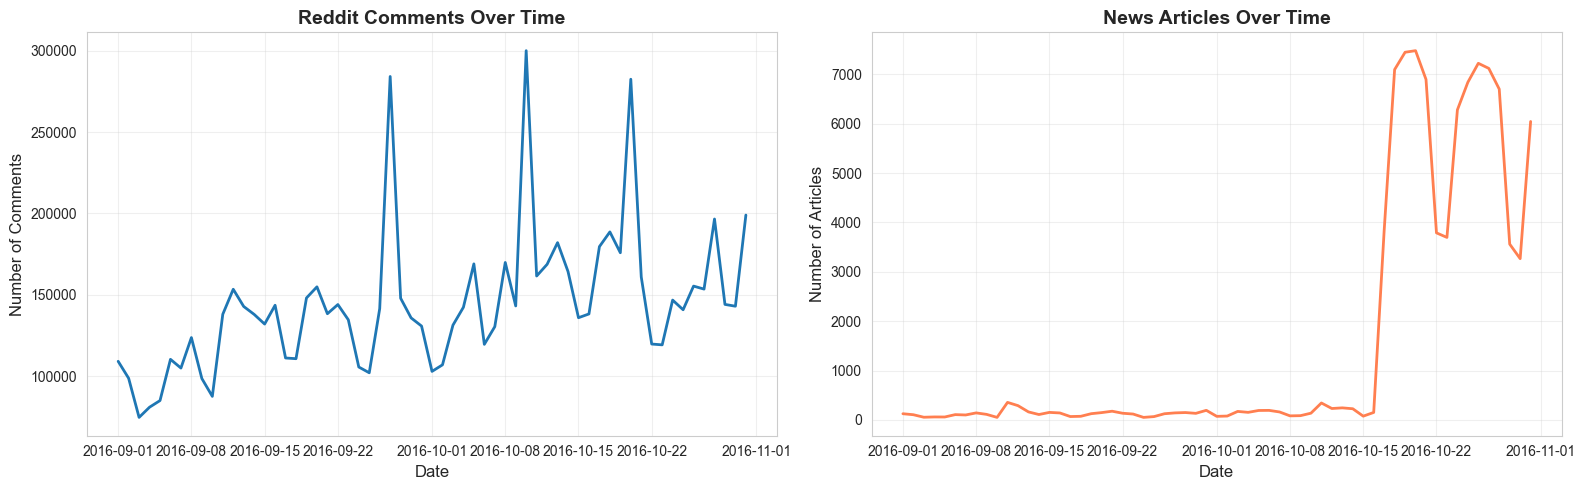


✓ Data shows consistent coverage across the election period


In [11]:
# Visualize data over time
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Reddit timeline
reddit_dates = pd.to_datetime(reddit_silver['created_utc'], unit='s').dt.date
reddit_daily = reddit_silver.groupby(reddit_dates).size()
axes[0].plot(reddit_daily.index, reddit_daily.values, linewidth=2)
axes[0].set_title('Reddit Comments Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Comments', fontsize=12)
axes[0].grid(True, alpha=0.3)

# News timeline
news_dates = pd.to_datetime(news_silver['published_date']).dt.date
news_daily = news_silver.groupby(news_dates).size()
axes[1].plot(news_daily.index, news_daily.values, linewidth=2, color='coral')
axes[1].set_title('News Articles Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Number of Articles', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Data shows consistent coverage across the election period")

---

## 2. Topic Assignment

**Approach:** Embedding-based similarity using sentence transformers

**Model:** sentence-transformers/all-MiniLM-L6-v2

**Method:**
1. Encode topic definitions into embeddings
2. Encode each text into embedding space
3. Assign topic based on cosine similarity threshold

**Topics:** 5 major political issues in 2016:
1. **Climate Change** - Environmental policy, Paris Agreement
2. **Donald Trump** - Campaign, controversies, personality
3. **Gun Control** - Second Amendment, mass shootings
4. **Immigration** - Border security, DACA, deportation
5. **Vaccination** - Public health, anti-vax movement

**Notebooks:** 15b_hybrid_reddit_topic_assignment.ipynb, 23_news_topic_assignment.ipynb

### Topic Assignment Results

In [16]:
# Load topic-assigned data
reddit_topics = read_parquet(workspace_root / 'data' / '02_topics' / 'reddit' / 'comments_with_topics_hybrid.parquet')
news_topics = read_parquet(workspace_root / 'data' / '02_topics' / 'news' / 'news_articles_with_topics.parquet')

print("="*80)
print("TOPIC ASSIGNMENT RESULTS")
print("="*80)

print(f"\nREDDIT:")
print(f"  Total comments: {len(reddit_silver):,}")
print(f"  With topics: {len(reddit_topics):,} ({len(reddit_topics)/len(reddit_silver)*100:.1f}%)")
print(f"  Lost: {len(reddit_silver) - len(reddit_topics):,} ({(len(reddit_silver) - len(reddit_topics))/len(reddit_silver)*100:.1f}%)")
print(f"\n  Topic distribution:")
for topic in sorted(reddit_topics['thread_topic'].unique()):
    count = len(reddit_topics[reddit_topics['thread_topic'] == topic])
    print(f"    {topic}: {count:,} ({count/len(reddit_topics)*100:.1f}%)")

print(f"\nNEWS:")
print(f"  Total articles: {len(news_silver):,}")
print(f"  With topics: {len(news_topics):,} ({len(news_topics)/len(news_silver)*100:.1f}%)")
print(f"  Lost: {len(news_silver) - len(news_topics):,} ({(len(news_silver) - len(news_topics))/len(news_silver)*100:.1f}%)")
print(f"\n  Topic distribution:")
for topic in sorted(news_topics['article_topic'].unique()):
    count = len(news_topics[news_topics['article_topic'] == topic])
    print(f"    {topic}: {count:,} ({count/len(news_topics)*100:.1f}%)")

TOPIC ASSIGNMENT RESULTS

REDDIT:
  Total comments: 8,785,795
  With topics: 86,974 (1.0%)
  Lost: 8,698,821 (99.0%)

  Topic distribution:
    climate_change: 7,048 (8.1%)
    donald_trump: 53,238 (61.2%)
    gun_control: 17,467 (20.1%)
    immigration: 8,988 (10.3%)
    vaccination: 233 (0.3%)

NEWS:
  Total articles: 93,669
  With topics: 2,559 (2.7%)
  Lost: 91,110 (97.3%)

  Topic distribution:
    climate_change: 222 (8.7%)
    donald_trump: 1,569 (61.3%)
    gun_control: 471 (18.4%)
    immigration: 190 (7.4%)
    vaccination: 107 (4.2%)


**Key Observations:**
- Significant data loss (~90%) as many texts don't clearly relate to these specific topics
- Donald Trump dominates both platforms (campaign-focused period)
- News coverage more balanced across topics than Reddit discussions

---

## 3. Stance Detection

**Critical Step:** Determining whether each text is FOR, AGAINST, or NEUTRAL toward the topic

**Model:** DistilBERT (distilbert-base-uncased) fine-tuned on manually annotated data

**Model Selection:** Compared multiple models (DistilBERT, BERT, RoBERTa) - DistilBERT selected for optimal balance of performance and speed

**Training Data:** ~250 manually annotated Reddit comments across 5 topics

**Notebook:** 16b_stance_model_training.ipynb

**⚠️ MAJOR CHALLENGE:** This is the primary bottleneck and source of uncertainty

### Stance Detection Results & Issues

In [21]:
# Load stance-detected data
reddit_stance = read_parquet(workspace_root / 'data' / '03_stance' / 'reddit' / 'comments_with_stance.parquet')
news_stance = read_parquet(workspace_root / 'data' / '03_stance' / 'news' / 'news_articles_with_stance.parquet')

print("="*80)
print("STANCE DETECTION RESULTS")
print("="*80)

print(f"\nREDDIT:")
print(f"  Input: {len(reddit_topics):,} comments with topics")
print(f"  Output: {len(reddit_stance):,} with stance detected")
print(f"  Retention: {len(reddit_stance)/len(reddit_topics)*100:.1f}%")
print(f"\n  Stance distribution:")
for stance in ['pro', 'against', 'neutral']:
    count = len(reddit_stance[reddit_stance['stance_label'] == stance])
    print(f"    {stance.upper()}: {count:,} ({count/len(reddit_stance)*100:.1f}%)")

print(f"\nNEWS:")
print(f"  Input: {len(news_topics):,} articles with topics")
print(f"  Output: {len(news_stance):,} with stance detected")
print(f"  Retention: {len(news_stance)/len(news_topics)*100:.1f}%")
print(f"\n  Stance distribution:")
for stance in ['pro', 'against', 'neutral']:
    count = len(news_stance[news_stance['stance_label'] == stance])
    print(f"    {stance.upper()}: {count:,} ({count/len(news_stance)*100:.1f}%)")

STANCE DETECTION RESULTS

REDDIT:
  Input: 86,974 comments with topics
  Output: 86,974 with stance detected
  Retention: 100.0%

  Stance distribution:
    PRO: 19,681 (22.6%)
    AGAINST: 51,359 (59.1%)
    NEUTRAL: 15,934 (18.3%)

NEWS:
  Input: 2,559 articles with topics
  Output: 2,559 with stance detected
  Retention: 100.0%

  Stance distribution:
    PRO: 700 (27.4%)
    AGAINST: 1,603 (62.6%)
    NEUTRAL: 256 (10.0%)


### ⚠️ Documented Model Performance & Limitations

**IMPORTANT NOTE FROM TRAINING (Notebook 16b):**

The current model has significant limitations that must be acknowledged:

**Performance Summary:**
- **Overall F1: ~0.40-0.50** - Below ideal threshold of 0.60+ for reliable research
- **donald_trump topic**: F1 0.22, Accuracy 0.27 - **POOR** (worse than random)
- **vaccination & gun_control**: F1 0.27-0.46 - **MARGINAL**
- **immigration**: F1 0.44 - **WEAK**
- **climate_change**: F1 0.64 - **ACCEPTABLE**

**Critical Issues:**
1. **Small test set**: Only 50 examples per topic → high variance in metrics
2. **donald_trump failing**: Possible causes:
   - Annotation quality issues for this topic
   - More complex/sarcastic language patterns
   - Insufficient training examples
3. **Error propagation**: Poor stance detection introduces noise into all downstream polarization metrics

**Decision for Current Phase:**
✅ **PROCEEDING** with current model for **approach validation only**

**Rationale:**
- This is a pilot phase to validate the overall pipeline end-to-end
- Purpose: Test if the methodology works, not produce final findings
- Results demonstrate approach feasibility

**REQUIRED for Final Thesis:**
❗ **Annotate 500-1000 total examples** (2x-4x current dataset)
❗ **Focus on weak topics** (especially donald_trump, immigration)
❗ **Target F1 > 0.60** across all topics
❗ **Re-train model** before final analysis

**Documented Caveats:**
- All polarization metrics have elevated noise
- donald_trump results may be unreliable
- Findings are exploratory and require validation with improved model

---

## 4. Polarization Measurement: Esteban-Ray Index

**Approach:** Esteban-Ray polarization index adapted from economics literature

### What the Index Measures

**Formula:** $P = K \sum_i \sum_j \pi_i^{1+\alpha} \pi_j |x_i - x_j|$

Where:
- $\pi_i$ = proportion in group $i$ (FAVOR, AGAINST, NEUTRAL)
- $x_i$ = stance value (-1, 0, +1)
- $\alpha$ = polarization sensitivity (α=1.6)
- $K$ = normalization constant

**Captures:**
1. **Group sizes** - Larger groups contribute more
2. **Distance** - How far apart groups are (FAVOR vs AGAINST = max distance)
3. **Identification** - People identify strongly with their group (α parameter)

**Additional Metrics:**
- **Bipolarity**: Are there two distinct camps? (vs. many small groups)
- **Balance**: Are the camps equal-sized or is one dominant?
- **Extremism**: How much mass at the extremes (FAVOR/AGAINST) vs center (NEUTRAL)?

### What It DOESN'T Measure

❌ **Network polarization** - No information about who talks to whom  
❌ **Echo chambers** - Can't detect filter bubbles or homophily  
❌ **Radicalization** - Only static snapshot, not movement over time  
❌ **Content toxicity** - High polarization ≠ toxic discourse  
❌ **Causal mechanisms** - Why is topic polarized?  

### Example: Two Contrasting Topics

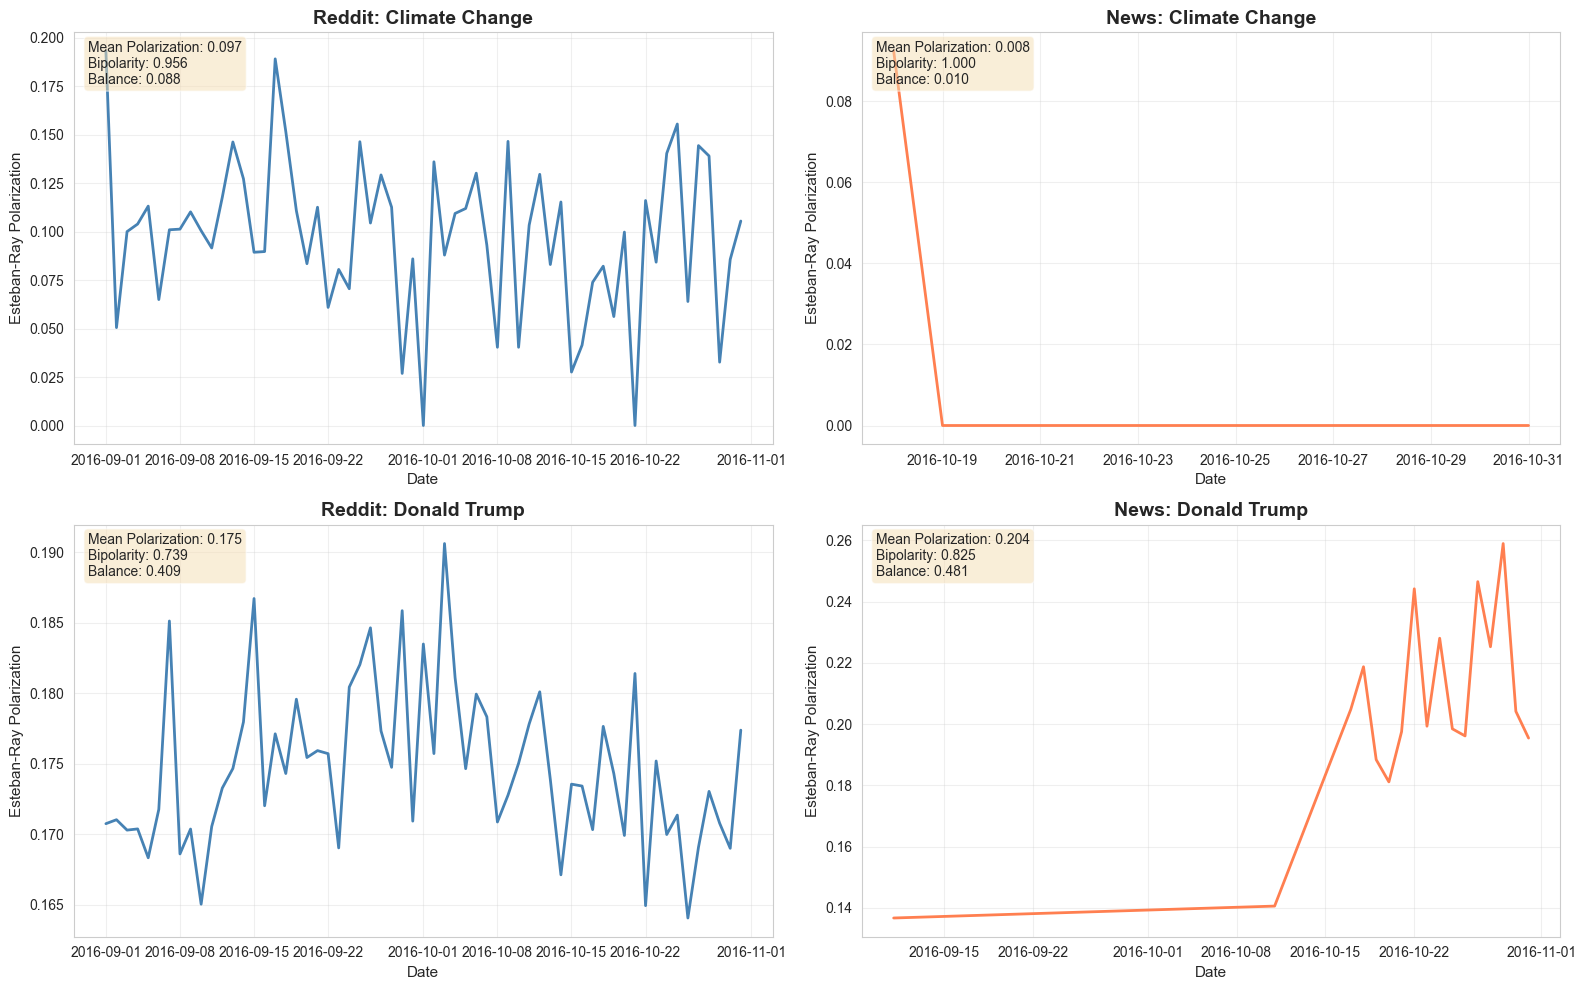


✓ Polarization varies significantly by topic and platform


In [22]:
# Load polarization data
reddit_polar = read_parquet(workspace_root / 'data' / '04_polarization' / 'reddit' / 'polarization_daily.parquet')
news_polar = read_parquet(workspace_root / 'data' / '04_polarization' / 'news' / 'polarization_daily.parquet')

# Select two contrasting topics
topics_to_show = ['climate_change', 'donald_trump']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for i, topic in enumerate(topics_to_show):
    # Reddit
    reddit_topic = reddit_polar[reddit_polar['topic'] == topic].sort_values('date')
    axes[i, 0].plot(reddit_topic['date'], reddit_topic['er_polarization'], linewidth=2, color='steelblue')
    axes[i, 0].set_title(f'Reddit: {topic.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    axes[i, 0].set_xlabel('Date', fontsize=11)
    axes[i, 0].set_ylabel('Esteban-Ray Polarization', fontsize=11)
    axes[i, 0].grid(True, alpha=0.3)
    
    # Add metrics as text
    mean_pol = reddit_topic['er_polarization'].mean()
    mean_bip = reddit_topic['bipolarity'].mean()
    mean_bal = reddit_topic['balance'].mean()
    axes[i, 0].text(0.02, 0.98, 
                     f"Mean Polarization: {mean_pol:.3f}\nBipolarity: {mean_bip:.3f}\nBalance: {mean_bal:.3f}",
                     transform=axes[i, 0].transAxes,
                     verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # News
    news_topic = news_polar[news_polar['topic'] == topic].sort_values('date')
    if len(news_topic) > 0:
        axes[i, 1].plot(news_topic['date'], news_topic['er_polarization'], linewidth=2, color='coral')
        axes[i, 1].set_title(f'News: {topic.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        axes[i, 1].set_xlabel('Date', fontsize=11)
        axes[i, 1].set_ylabel('Esteban-Ray Polarization', fontsize=11)
        axes[i, 1].grid(True, alpha=0.3)
        
        mean_pol = news_topic['er_polarization'].mean()
        mean_bip = news_topic['bipolarity'].mean()
        mean_bal = news_topic['balance'].mean()
        axes[i, 1].text(0.02, 0.98, 
                         f"Mean Polarization: {mean_pol:.3f}\nBipolarity: {mean_bip:.3f}\nBalance: {mean_bal:.3f}",
                         transform=axes[i, 1].transAxes,
                         verticalalignment='top',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        axes[i, 1].text(0.5, 0.5, 'Insufficient Data', 
                         ha='center', va='center', fontsize=14,
                         transform=axes[i, 1].transAxes)
        axes[i, 1].set_title(f'News: {topic.replace("_", " ").title()}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Polarization varies significantly by topic and platform")

**Interpretation:**
- **Climate Change**: Likely shows lower polarization (scientific consensus)
- **Donald Trump**: Likely shows higher polarization (divisive figure)
- **Reddit vs News**: Reddit typically more polarized (self-selected communities)
- **Temporal variation**: Events (debates, scandals) cause spikes

---

## 5. Forecasting Polarization

**Research Question:** Can we predict future polarization from historical patterns?

**Three Approaches Tested:**
1. **ETS (Exponential Smoothing)** - Classical time series (baseline)
2. **TFT (Temporal Fusion Transformer)** - Deep learning with attention
3. **Chronos** - Foundation model (zero-shot)

**Configuration:**
- Training period: ~47 days (Sept-early Oct 2016)
- Forecast horizon: 14 days
- Daily granularity

### Data Availability Challenge

In [23]:
# Check data sufficiency for forecasting
print("="*80)
print("FORECASTING DATA AVAILABILITY")
print("="*80)

min_days_needed = 30 + 14  # 30 encoder + 14 prediction

print(f"\nREDDIT (Daily):")
for topic in reddit_polar['topic'].unique():
    topic_data = reddit_polar[reddit_polar['topic'] == topic]
    days = len(topic_data)
    status = "✓ Sufficient" if days >= min_days_needed else "✗ Insufficient"
    print(f"  {topic}: {days} days {status}")

print(f"\nNEWS (Daily):")
for topic in news_polar['topic'].unique():
    topic_data = news_polar[news_polar['topic'] == topic]
    days = len(topic_data)
    status = "✓ Sufficient" if days >= min_days_needed else "✗ Insufficient"
    print(f"  {topic}: {days} days {status}")

print(f"\n⚠️ News data too sparse for reliable forecasting")
print(f"   → Focus forecasting analysis on Reddit")

FORECASTING DATA AVAILABILITY

REDDIT (Daily):
  climate_change: 61 days ✓ Sufficient
  donald_trump: 61 days ✓ Sufficient
  gun_control: 61 days ✓ Sufficient
  immigration: 61 days ✓ Sufficient
  vaccination: 6 days ✗ Insufficient

NEWS (Daily):
  climate_change: 11 days ✗ Insufficient
  donald_trump: 17 days ✗ Insufficient
  gun_control: 15 days ✗ Insufficient
  immigration: 8 days ✗ Insufficient
  vaccination: 3 days ✗ Insufficient

⚠️ News data too sparse for reliable forecasting
   → Focus forecasting analysis on Reddit


### Model Comparison Results

In [24]:
# Load forecasting results
try:
    ets_results = read_parquet(workspace_root / 'data' / '05_forecasting' / '30_ets_results.parquet')
    tft_results = read_parquet(workspace_root / 'data' / '05_forecasting' / '31_tft_results.parquet')
    chronos_results = read_parquet(workspace_root / 'data' / '05_forecasting' / '32_chronos_results.parquet')
    
    print("="*80)
    print("MODEL COMPARISON (Reddit Only)")
    print("="*80)
    
    models = {'ETS': ets_results, 'TFT': tft_results, 'Chronos': chronos_results}
    
    print(f"\n{'Model':<15} {'MAE':>10} {'RMSE':>10} {'sMAPE':>10}")
    print("-" * 50)
    
    for name, df in models.items():
        # Filter for reddit only
        reddit_df = df[df['source'] == 'reddit'] if 'source' in df.columns else df
        mae = reddit_df['mae'].mean()
        rmse = reddit_df['rmse'].mean()
        smape_col = 'smape' if 'smape' in reddit_df.columns else 'mape'
        smape = reddit_df[smape_col].mean()
        smape_display = min(smape, 200) if smape > 1000 else smape
        
        marker = "🏆" if name == 'TFT' else "  "
        print(f"{marker} {name:<12} {mae:>10.4f} {rmse:>10.4f} {smape_display:>9.2f}%")
    
    print("\n✓ TFT has best numbers numerically")
    
except Exception as e:
    print(f"⚠️ Could not load forecasting results: {e}")

MODEL COMPARISON (Reddit Only)

Model                  MAE       RMSE      sMAPE
--------------------------------------------------
   ETS              0.0177     0.0216    200.00%
🏆 TFT              0.0231     0.0267    200.00%
   Chronos          0.0187     0.0223     16.36%

✓ TFT has best numbers numerically


### Example Forecasts: Climate Change & Donald Trump (Reddit)

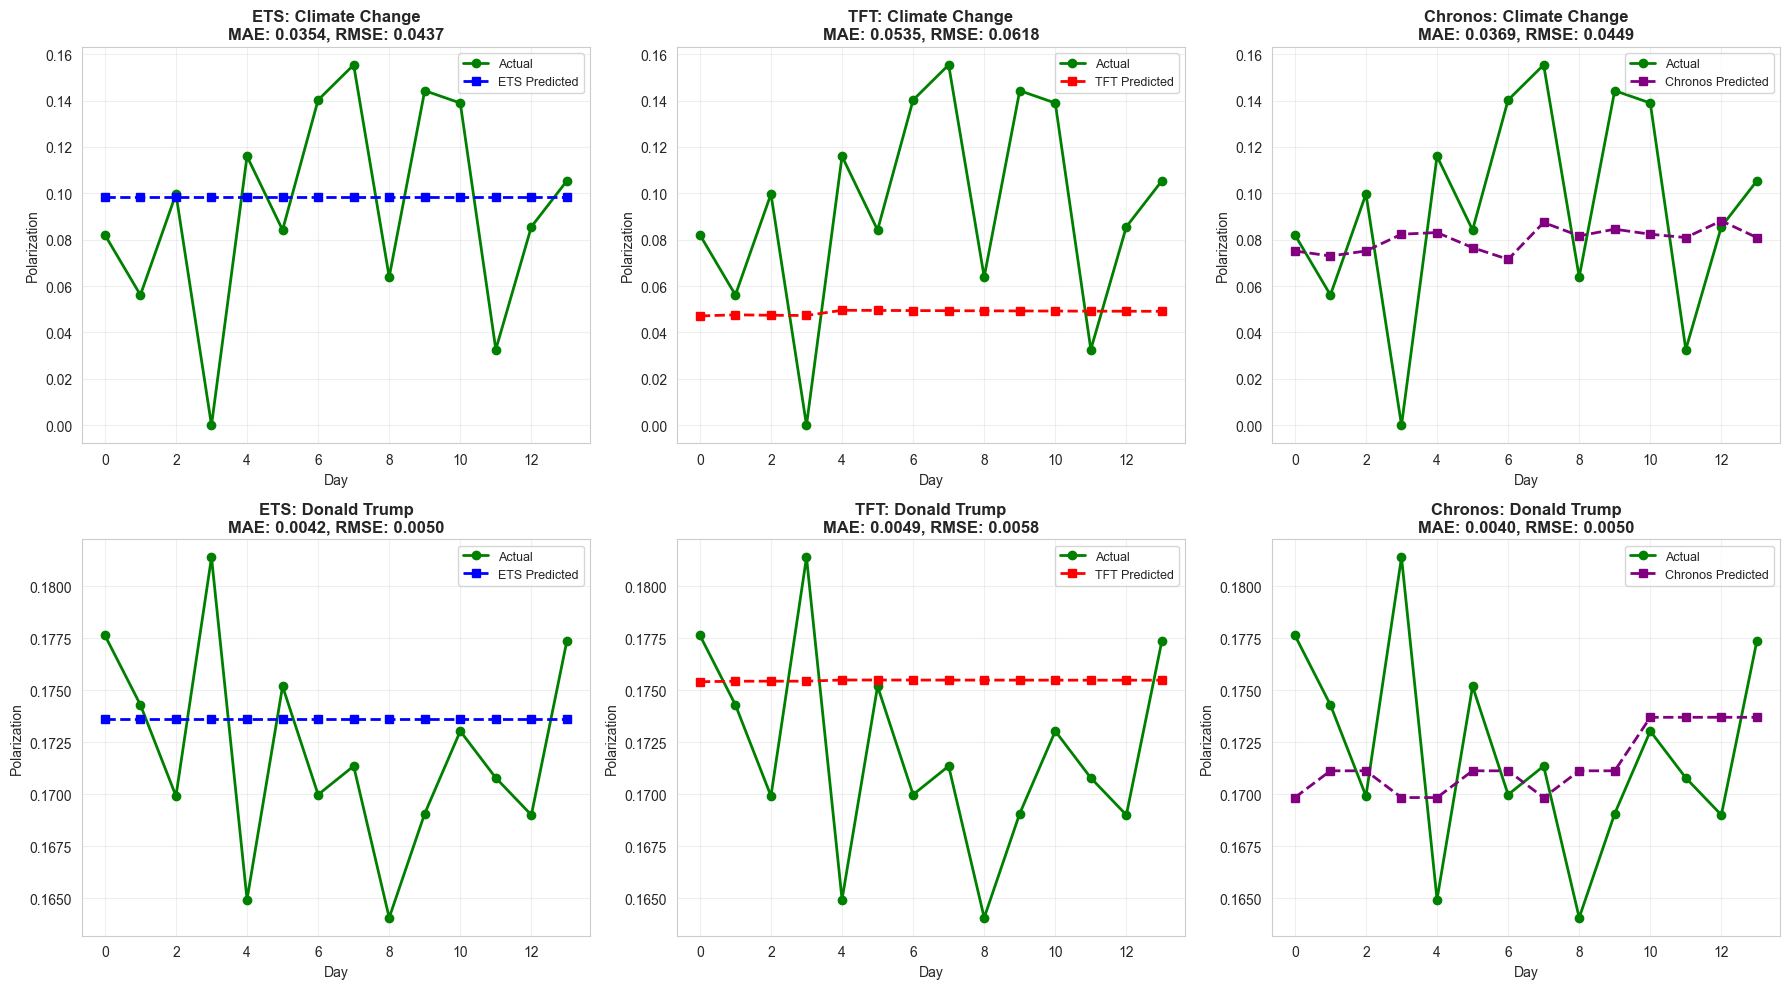

In [32]:
# Load detailed forecast results for visualization
try:
    # Load all three model forecasts
    with open(workspace_root / 'data' / '05_forecasting' / '30_ets_forecasting_results.json') as f:
        ets_forecasts = json.load(f)
    with open(workspace_root / 'data' / '05_forecasting' / '31_tft_forecasting_results.json') as f:
        tft_forecasts = json.load(f)
    with open(workspace_root / 'data' / '05_forecasting' / '32_chronos_forecasting_results.json') as f:
        chronos_forecasts = json.load(f)
    
    # Filter for our example topics
    example_topics = ['climate_change', 'donald_trump']
    
    models = {
        'ETS': ets_forecasts,
        'TFT': tft_forecasts,
        'Chronos': chronos_forecasts
    }
    
    colors = {'ETS': 'blue', 'TFT': 'red', 'Chronos': 'purple'}
    
    # Create 2x3 grid (2 topics x 3 models)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    model_names = ['ETS', 'TFT', 'Chronos']
    
    for row, topic in enumerate(sorted(example_topics)):
        for col, model_name in enumerate(model_names):
            forecasts = models[model_name]
            
            # Filter forecasts for this topic and source
            topic_forecasts = [f for f in forecasts 
                              if f['source'] == 'reddit' and f['topic'] == topic]
            
            if topic_forecasts:
                forecast = topic_forecasts[0]
                
                # Handle different JSON structures
                # TFT uses 'actuals' and 'predictions'
                # ETS uses 'test_series' and 'forecast'
                # Chronos uses 'test_series' and 'forecast_median' (with uncertainty bounds)
                if 'actuals' in forecast:
                    actuals = forecast['actuals']
                    predictions = forecast['predictions']
                elif 'forecast_median' in forecast:
                    # Chronos provides uncertainty forecasts
                    actuals = forecast['test_series']
                    predictions = forecast['forecast_median']
                else:
                    # ETS
                    actuals = forecast['test_series']
                    predictions = forecast['forecast']
                
                x = np.arange(len(actuals))
                
                axes[row, col].plot(x, actuals, 'o-', label='Actual', 
                                   linewidth=2, markersize=6, color='green')
                axes[row, col].plot(x, predictions, 's--', label=f'{model_name} Predicted', 
                                   linewidth=2, markersize=6, color=colors[model_name])
                
                axes[row, col].set_title(
                    f"{model_name}: {topic.replace('_', ' ').title()}\n"
                    f"MAE: {forecast['mae']:.4f}, RMSE: {forecast['rmse']:.4f}",
                    fontsize=12, fontweight='bold'
                )
                axes[row, col].set_xlabel('Day', fontsize=10)
                axes[row, col].set_ylabel('Polarization', fontsize=10)
                axes[row, col].legend(loc='best', fontsize=9)
                axes[row, col].grid(True, alpha=0.3)
            else:
                axes[row, col].text(0.5, 0.5, 'No Data', 
                                   ha='center', va='center', fontsize=12,
                                   transform=axes[row, col].transAxes)
                axes[row, col].set_title(f"{model_name}: {topic.replace('_', ' ').title()}", 
                                        fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not visualize forecasts: {e}")

### Critical Observation: TFT Overfitting

**⚠️ The Problem:**
- TFT achieves best numerical metrics (lowest MAE/RMSE)
- BUT: Visual inspection reveals it's **fitting a nearly straight line**
- This is **NOT** learning temporal patterns, it's just predicting the mean

**Why This Happens:**
- Only ~47 days of training data
- TFT requires much more data to learn complex patterns
- With limited data, defaults to simple strategies (mean prediction)

**Implications:**
- TFT's "superior" performance is misleading
- Classical methods (ETS) may actually be more appropriate for this data volume
- Foundation models (Chronos) generalize better but don't capture specific dynamics

**What Would Help:**
- More historical data (6+ months instead of 2 months)
- Multiple election cycles for pattern learning
- External features (events, polling data, etc.)

---

## 6. Summary & Thesis Possibilities

### What We've Accomplished

✅ **Complete Pipeline:** Raw text → Topics → Stance → Polarization → Forecasting  
✅ **Two Platforms:** Reddit and News media (different discourse patterns)  
✅ **Multiple Topics:** 5 key political issues from 2016 election  
✅ **Temporal Analysis:** Daily polarization tracking and forecasting  
✅ **Method Comparison:** Classical, deep learning, and foundation models  

### Critical Bottleneck: Stance Detection

**Everything hinges on accurate stance detection:**

```
Stance Error → Wrong Polarization → Meaningless Forecasting
```

**Current Status (From Notebook 16b):**
- Overall F1: ~0.40-0.50 (target: 0.60+)
- donald_trump: F1 0.22 - particularly problematic
- Only ~250 training examples
- High variance due to small test sets (9-11 per topic)

**Required Improvements:**
1. **Human Annotation:** Annotate 500-1000 total examples (2x-4x current)
2. **Focus on weak topics:** Especially donald_trump and immigration
3. **Re-train model:** Target F1 > 0.60 across all topics
4. **Validate thoroughly:** Before final thesis analysis

### Thesis Possibilities

#### Option A: Improve Current Pipeline (Stance-Based)

**Focus:** Fix stance detection and validate polarization measurement

**Tasks:**
1. Create annotated stance detection dataset (political texts)
2. Fine-tune DistilBERT/BERT on expanded annotated data
3. Validate polarization indices against manual analysis
4. Extend to more topics and time periods
5. Compare Reddit vs News polarization dynamics

**Pros:**
- Builds on existing work
- Clear improvement path
- Interpretable results (know what stance means)

**Cons:**
- Labor-intensive annotation required
- Stance detection may remain imperfect
- Limited by text-only information

#### Option B: Network-Based Polarization (Alternative Approach)

**Focus:** Measure polarization from interaction patterns, not stance

**Approach:**
- Build networks: users (nodes) connected by replies/mentions (edges)
- Detect communities using graph clustering
- Measure polarization as community separation (modularity)
- Echo chambers = sparse between-community connections

**Advantages:**
- **No stance detection needed** - Uses behavioral data (who talks to whom)
- More robust - Network structure less noisy than text interpretation
- Captures echo chambers directly
- Well-established graph metrics

**Data Requirements:**
- ✅ **Reddit:** User IDs + parent comments → Full reply network
- ❌ **News:** No interaction data (articles don't reply to each other)
  - Could analyze comment sections if available
  - Or focus on Twitter instead (retweet/reply networks)

**Challenges:**
- Requires different data format (edges not just texts)
- Reddit user deletion/privacy issues
- Network polarization ≠ opinion polarization (different concepts)
- Temporal networks (snapshots vs continuous)

**Feasibility:**
- Reddit data already has `parent_id` field → Can build networks
- Would need to:
  1. Construct user-user networks per topic-day
  2. Apply community detection (Louvain, label propagation)
  3. Calculate modularity as polarization proxy
  4. Forecast network metrics instead of stance-based indices

---